# 3D Metrics

To assess segmentation performance in 3D, we can use metrics from the `vl` (volume) accessor.

**NOTE:** This module is still experimental and will change substantially in upcoming releases.

To follow along with this tutorial, you can download the data from [here](https://oc.embl.de/index.php/s/1JyN4Qvk4mw0T5J).

## Correlations between the top and bottom of the slice

To assess if there are cells lying on top of each other in the z plane, we can slice our data into a top and bottom plane, e. g. by taking the top 25% and the bottom 25%. We can then compute the Pearson correlation between the two planes for each cell. If the correlation is high, the top and bottom layers likely show the same cell. If it is low, there might be two or more cells overlapping in the z direction.

In [2]:
%load_ext autoreload
%autoreload 2

import copy

import matplotlib.pyplot as plt
import seaborn as sns
import spatialdata as sd
import spatialdata_plot  # noqa

import segtraq

st = segtraq.SegTraQ(
    sd.read_zarr("../../data/proseg2.zarr"),
    images_key="image",
    points_background_id=0,
    tables_area_volume_key="volume",
    tables_x_key="centroid_x",
    tables_y_key="centroid_y",
)

version mismatch: detected: RasterFormatV02, requested: FormatV04


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/.venv/lib/python3.13/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/g/huber/users/meyerben/notebooks/spatial_transcriptomics/SegTraQ/src/segtraq/SegTraQ.py:128: UserWarning: Missing 4 cell IDs in shapes: [np.int64(11273), np.int64(10307), np.int64(10308), np.int64(6870)]... These cells are present in tables, but not in shapes. This might lead to inconsistencies in the spatialdata object.
  validate_spatialdata(


In [46]:
correlation_df = st.vl.compute_z_plane_correlation()
# removing the unassigned transcripts
correlation_df = correlation_df[correlation_df.index != 0]
correlation_df.head()

correlation
cell_id             
1           0.360827
2          -0.001534
3          -0.000375
4           0.046278
5           0.110641

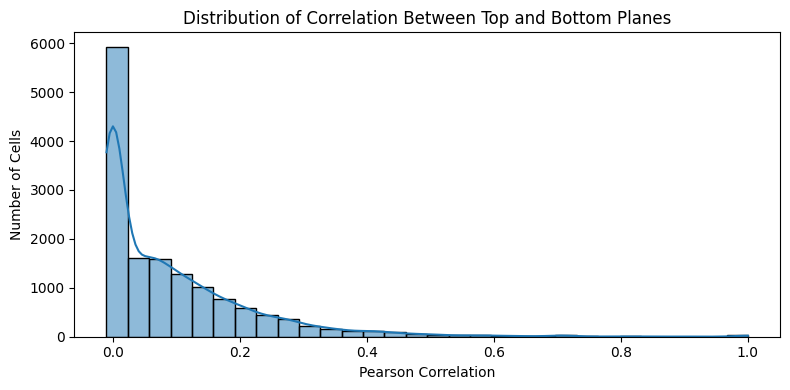

In [47]:
# Plot the distribution of correlation values
plt.figure(figsize=(8, 4))
sns.histplot(correlation_df["correlation"], bins=30, kde=True)

plt.title("Distribution of Correlation Between Top and Bottom Planes")
plt.xlabel("Pearson Correlation")
plt.ylabel("Number of Cells")
plt.tight_layout()
plt.show()

INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' to disable this    
         behaviour.                                                                                                
INFO     Using the datashader reduction "mean". "max" will give an output very close to the matplotlib result.     


Processing IoU between overlapping cells:   0%|          | 0/17881 [17:19<?, ?it/s]


INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' to disable this    
         behaviour.                                                                                                
INFO     Using the datashader reduction "mean". "max" will give an output very close to the matplotlib result.     


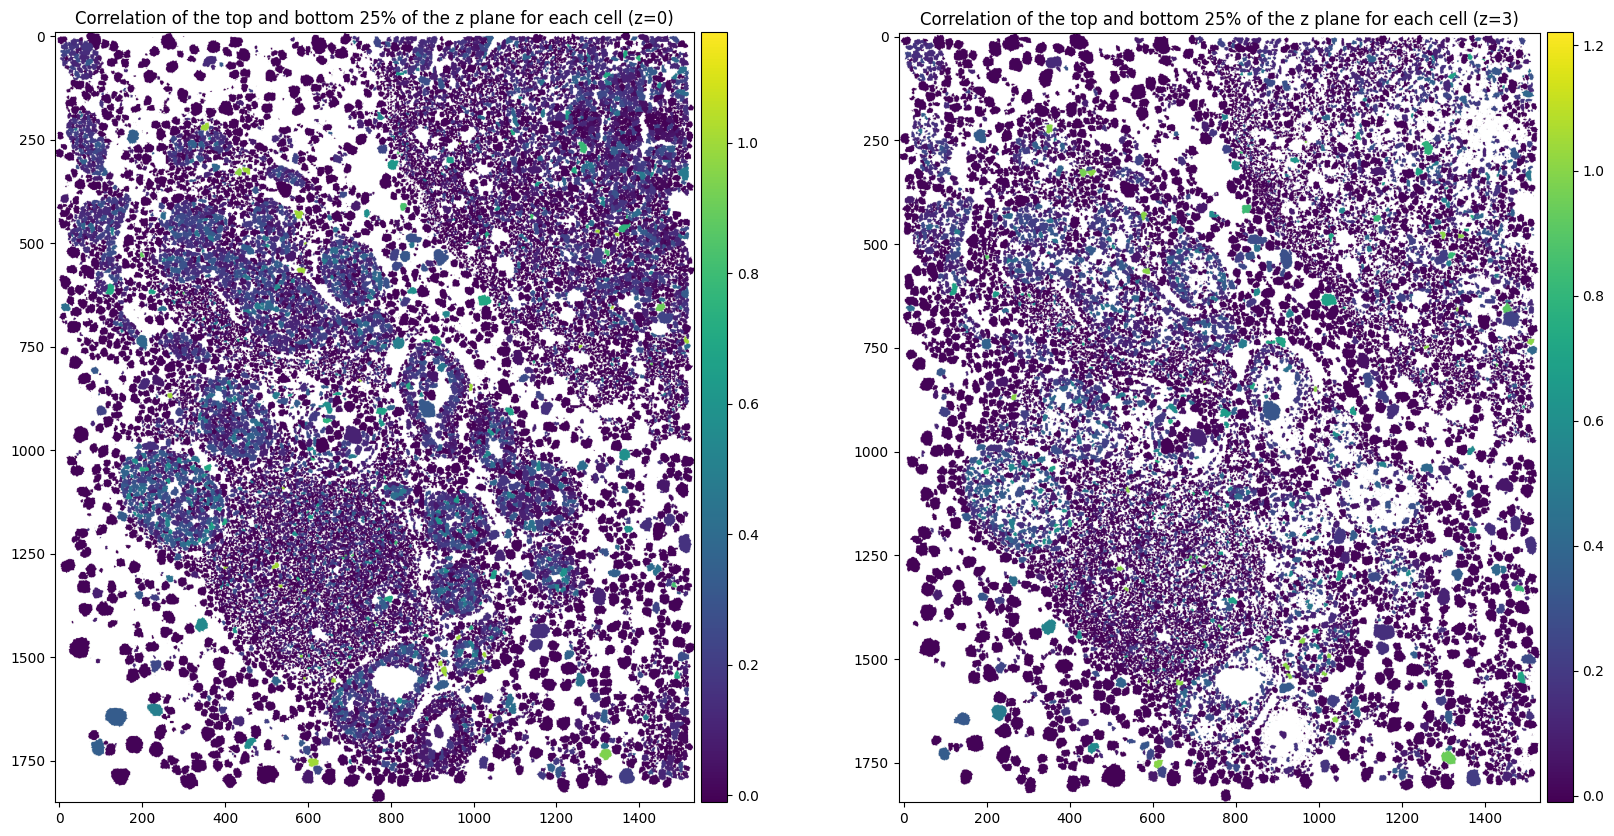

In [48]:
# plotting the correlation on the bottom and top plane respectively
fix, ax = plt.subplots(1, 2, figsize=(20, 10))

sdata_plot = copy.deepcopy(st.sdata)
sdata_plot.tables["table"].obs["region"] = "cell_boundaries_z0"
sdata_plot.set_table_annotates_spatialelement("table", region="cell_boundaries_z0")
sdata_plot.pl.render_shapes("cell_boundaries_z0", color="correlation").pl.show(
    title="Correlation of the top and bottom 25% of the z plane for each cell (z=0)",
    coordinate_systems="global",
    ax=ax[0],
)

sdata_plot = copy.deepcopy(st.sdata)
sdata_plot.tables["table"].obs["region"] = "cell_boundaries_z3"
sdata_plot.set_table_annotates_spatialelement("table", region="cell_boundaries_z3")
sdata_plot.pl.render_shapes("cell_boundaries_z3", color="correlation").pl.show(
    title="Correlation of the top and bottom 25% of the z plane for each cell (z=3)",
    coordinate_systems="global",
    ax=ax[1],
)

## Assessing physical overlap in 3D

We can assess the overlap of cell segmentation masks in the $z$-dimension by computing the intersetion-over-union (IoU) of a cell with all cell segmentations. This module only works for 3D segmented objects, so e.g. ProSeg. Other segmentations like Xenium only segment object in 2D and hence there is no overlap. The method outputs a list per cell where the length determines the number of overlaps a cell has and the IoU the relative overlap to the cell sizes. Furthermore, we calculate the sum of the IoU values as a measure of the total overlap a cell has. 

In [49]:
IoU_df = st.vl.compute_cell_cell_IoU(inplace=True)
IoU_df.head()

Processing IoU between overlapping cells: 100%|██████████| 17881/17881 [00:48<00:00, 365.61it/s]


IoU   IoU_sum
cell_id                                                             
1        [0.07564600348105502, 0.05148833467417538, 0.0...  0.281033
2        [0.04936905025459371, 0.01965083916673699, 0.0...  0.079871
3        [0.149425287356321, 0.08648648648648662, 0.078...  0.486786
4        [0.027488151658767772, 0.013598637432750256, 0...  0.042182
5        [0.061946902654866985, 0.0049172999552972736, ...  0.068120

Next, we will visualise the total overlap per cell in physical space. 

INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' to disable this    
         behaviour.                                                                                                
INFO     Using the datashader reduction "mean". "max" will give an output very close to the matplotlib result.     


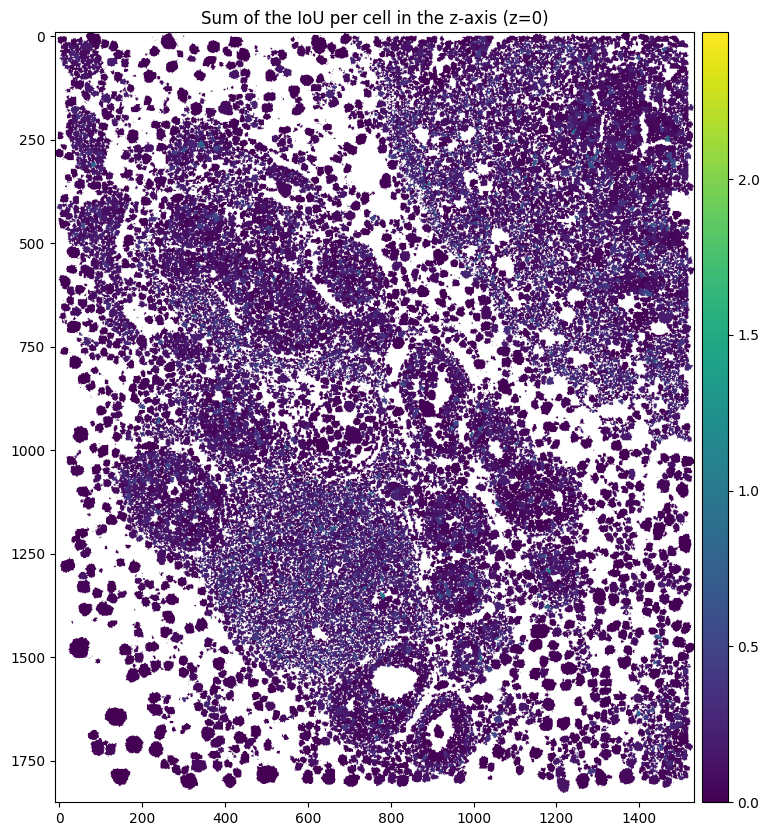

In [51]:
# plotting the correlation on the bottom and top plane respectively
fix, ax = plt.subplots(1, 1, figsize=(10, 10))

sdata_plot = copy.deepcopy(st.sdata)
sdata_plot.tables["table"].obs["region"] = "cell_boundaries_z0"
sdata_plot.set_table_annotates_spatialelement("table", region="cell_boundaries_z0")
sdata_plot.pl.render_shapes("cell_boundaries_z0", color="IoU_sum").pl.show(
    title="Sum of the IoU per cell in the z-axis (z=0)",
    coordinate_systems="global",
    ax=ax,
)

You can run all functions in the `vl` module using `run_volume()`.

In [52]:
st.run_volume()
st.sdata.tables["table"].obs

Processing IoU between overlapping cells: 100%|██████████| 17881/17881 [00:50<00:00, 354.00it/s]


cell_id  centroid_x   centroid_y  centroid_z       volume  label_id  \
0            1   154.66340  1053.593600   -0.115346  1131.674000         1   
1            2   348.67285   287.598750    0.524985   256.049380         2   
2            3   720.20215  1218.872300    0.660745   148.571900         3   
3            4   877.44590  1707.412100   -0.980020   233.921080         4   
4            5  1253.77540  1426.495100    0.859675   327.174870         5   
...        ...         ...          ...         ...          ...       ...   
17880    17881  1027.99170   123.166664   -1.144839   189.666200     17881   
17881    17882  1422.56730    47.375000    0.382015   164.377410     17882   
17882    17883   578.78050   966.006100    0.165542   259.210450     17883   
17883    17884   207.73756   364.975130    0.303928   286.080100     17884   
17884    17885   632.23975  1258.732900   -0.131373   115.380264     17885   

            region  correlation  \
0      cell_labels     0.360827   
1      cell_labels    -0.001534   
2      cell_labels    -0.000375   
3      cell_labels     0.046278   
4      cell_labels     0.110641   
...            ...          ...   
17880  cell_labels     0.000000   
17881  cell_labels     0.100298   
17882  cell_labels     0.203358   
17883  cell_labels    -0.002220   
17884  cell_labels    -0.001812   

                                                     IoU   IoU_sum  
0      [0.07564600348105502, 0.05148833467417538, 0.0...  0.281033  
1      [0.04936905025459371, 0.01965083916673699, 0.0...  0.079871  
2      [0.149425287356321, 0.08648648648648662, 0.078...  0.486786  
3      [0.027488151658767772, 0.013598637432750256, 0...  0.042182  
4      [0.061946902654866985, 0.0049172999552972736, ...  0.068120  
...                                                  ...       ...  
17880  [0.024620741109176836, 0.007439765203739646, 0...  0.042055  
17881  [0.011611704598235033, 0.005287508261731808, 0...  0.029509  
17882  [0.03856749311294766, 0.02576223115102837, 0.0...  0.114530  
17883  [0.00888878547079146, 0.0009791498675267663, 0...  0.010683  
17884  [0.13636363636363635, 0.05010893246187364, 0.0...  0.243642  

[17885 rows x 10 columns]